## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration using chessboard images

### Finding the chessboard corners
Using a slightly modified version of the code given in the course video. I plot all the calibration images with the chessboard corners (if found) drawn on top.

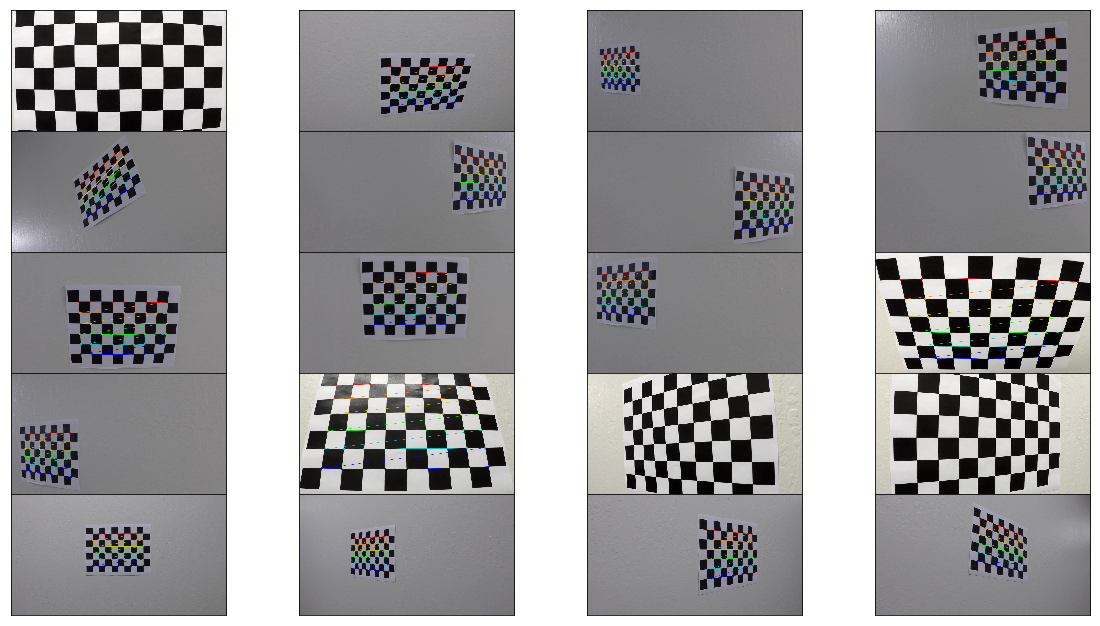

In [79]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(16, 9))
fig.tight_layout()
plt.subplots_adjust(left=0, right=1, wspace=0, hspace=0)
axes = axes.flatten()

# Step through the list and search for chessboard corners
for fname, axis in zip(images, axes):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    axis.imshow(bgr2rgb(img))
    axis.set_xticks([])
    axis.set_yticks([])

It seems findChessboardCorners() did not find the corners in images 1, 15 and 16, probably because not all of the 9x6 corners were visible in those images. 

### Calculating the camera calibration

In [61]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Checking the camera calibration

Lets check the distortion correction with image 1, where finding the corners failed:

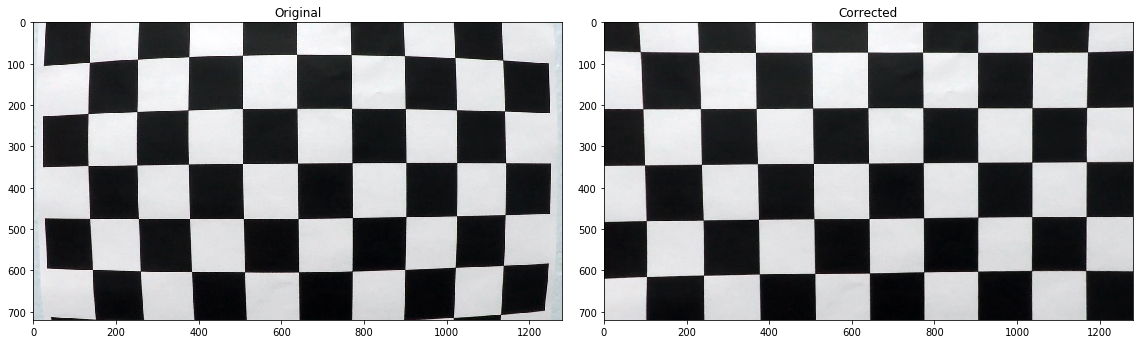

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
fig.tight_layout()

fname = 'camera_cal/calibration1.jpg'.format(n)
img = cv2.imread(fname)
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(dst)
ax2.set_title('Corrected')

The distorion correction does not look too bad, I think it is ok to proceed.

### Preprocessing the test images
Because I later need the test images I preload and undistort them here.

In [120]:
test_images = []
test_image_names = []

for fname in glob.glob('test_images/*.jpg'):
    print('Undistorting', fname)
    img = bgr2rgb(cv2.imread(fname))
    test_images.append(cv2.undistort(img, mtx, dist, None, mtx))
    # Store also the file names for later use
    test_image_names.append(fname)
    

Undistorting test_images/straight_lines1.jpg
Undistorting test_images/straight_lines2.jpg
Undistorting test_images/test1.jpg
Undistorting test_images/test2.jpg
Undistorting test_images/test3.jpg
Undistorting test_images/test4.jpg
Undistorting test_images/test5.jpg
Undistorting test_images/test6.jpg


## Converting images to binary

After removing camera distortion, the next operation in finding the lane lines is converting the image to a binary form where the lane lines are easier to detect. Here I chose to follow the basic process outlined in the videos:
1. Convert an image from RGB to HSL color space
1. Calculate x-gradient from the image L-channel and threshold the result
1. Threshold the image S-channel
1. Combine the thresholded binary images to a single binary image

In [101]:
def image_to_binary(image, grad_thresh=[20, 100], s_thresh=[170, 255]):
    # Convert to HLS
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    # Calculate x-gradient
    sobel_x = np.abs(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    sobel_x_scaled = np.uint8(255 * sobel_x / np.max(sobel_x))
    # Threshold the gradient to a boolean mask
    grad_mask = (sobel_x_scaled > grad_thresh[0]) & (sobel_x_scaled <= grad_thresh[1])
    # Threshold the s-channel to a boolean mask
    s_mask = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    # Return masks combined with OR and converted to 8-bit
    return np.uint8(grad_mask | s_mask)

Lets do the binary conversion for the test images and also check how they look:

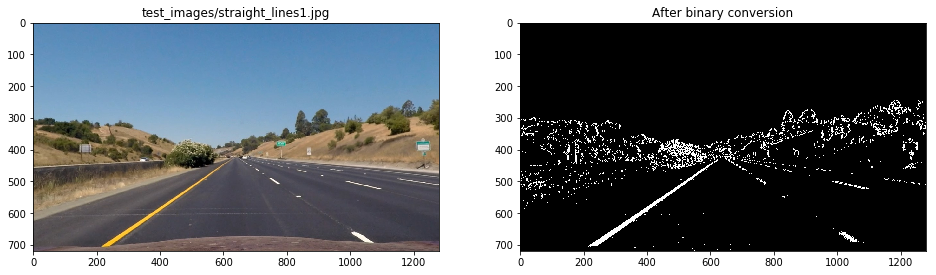

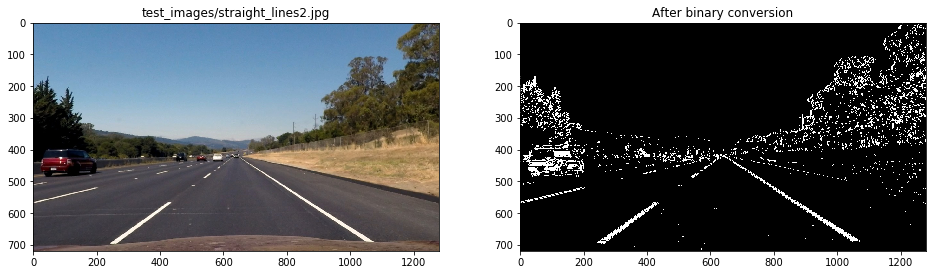

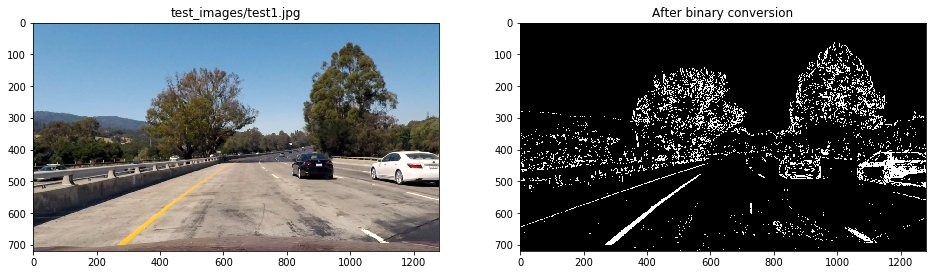

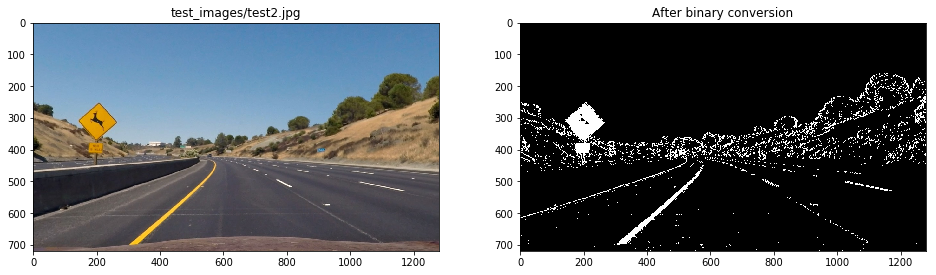

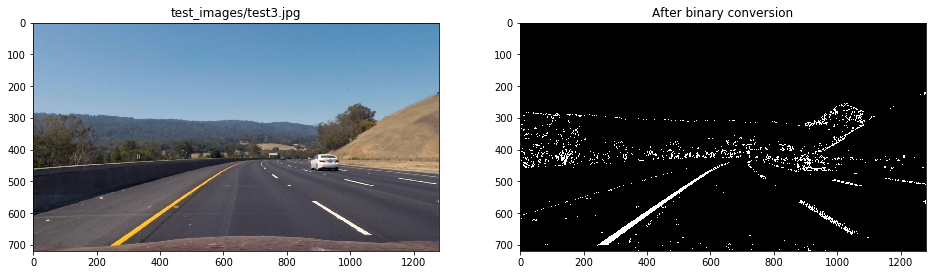

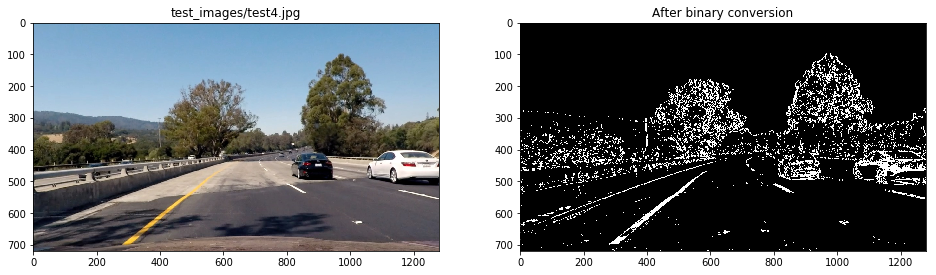

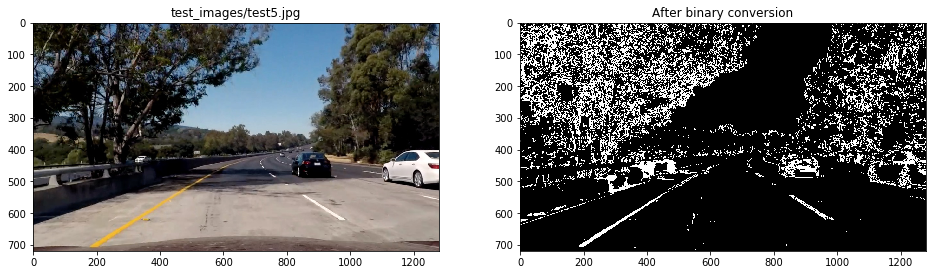

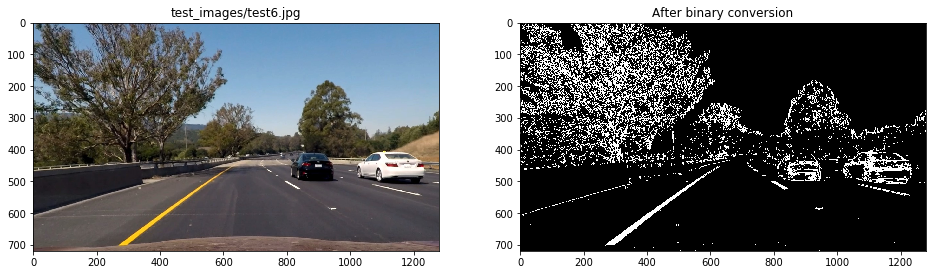

In [123]:
binary_test_images = []

for img, name in zip(test_images, test_image_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    ax1.imshow(img)
    ax1.set_title(name)
    binary_img = image_to_binary(img)
    binary_test_images.append(binary_img)
    ax2.imshow(binary_img, cmap='gray')
    ax2.set_title('After binary conversion')

The binary conversion seems to be doing its job for picking out the lane lines in the test images, so let's proceed to perpective transformation. 

## Perspective transform

[[   50.   720.]
 [  580.   450.]
 [  700.   450.]
 [ 1230.   720.]]
[[  200.   720.]
 [  200.     0.]
 [ 1080.     0.]
 [ 1080.   720.]]


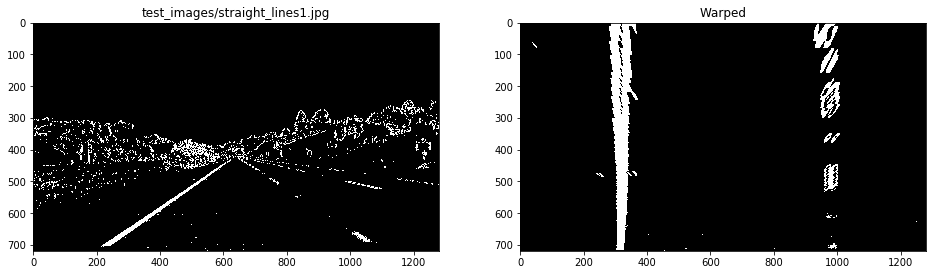

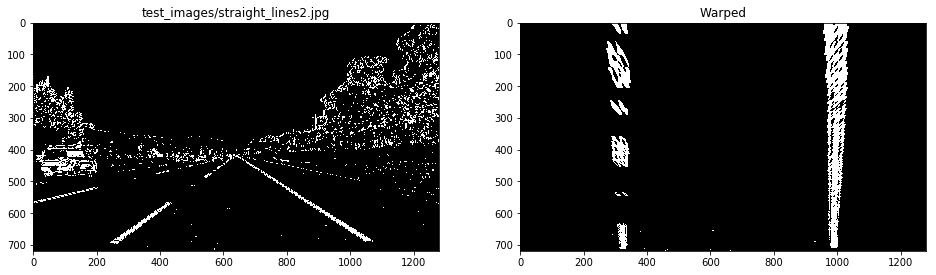

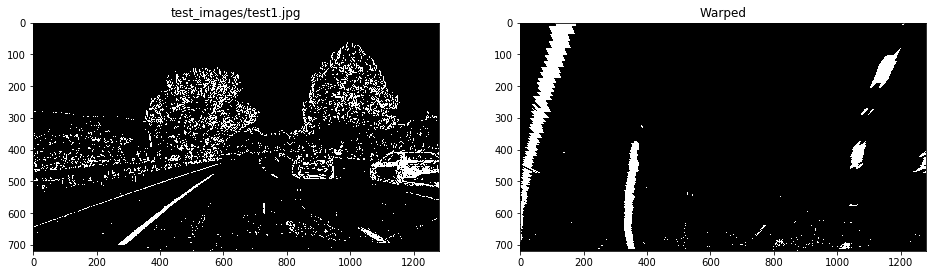

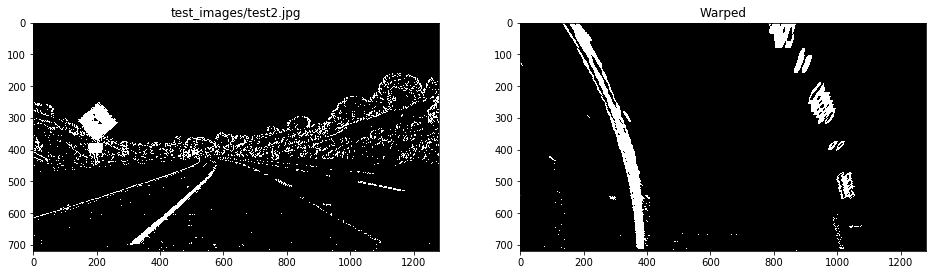

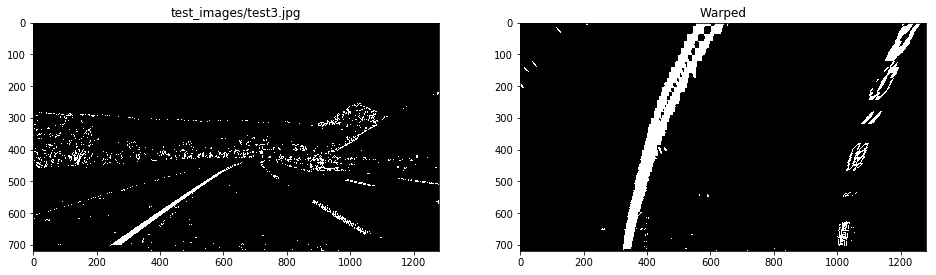

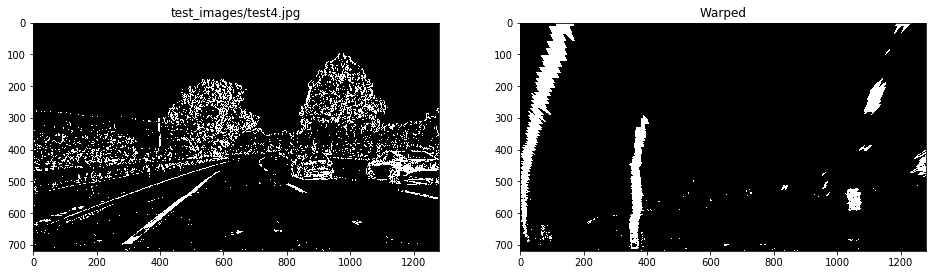

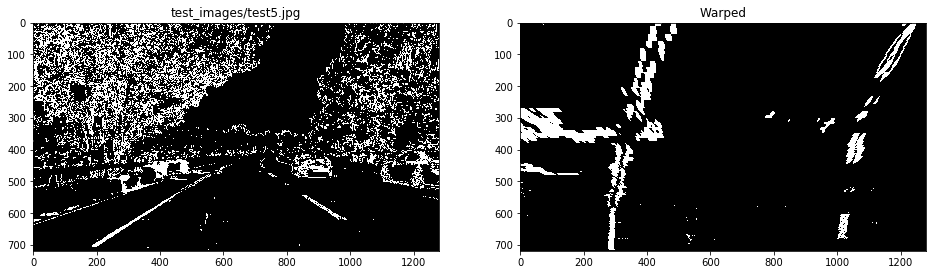

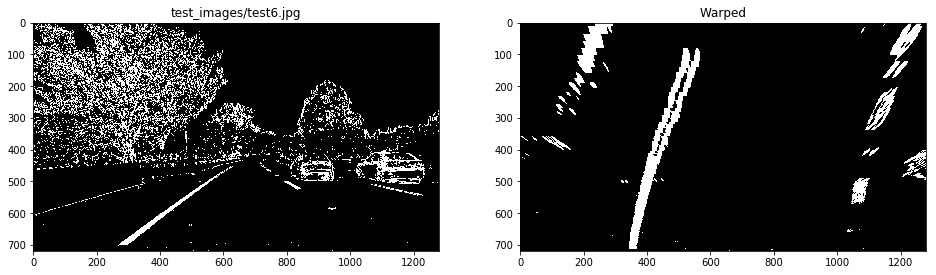

In [145]:
h, w = img_shape[0:2]
# Set up some variables for specifying the source parallelogram for perspective warping
top_width = 120
top_x = (w - top_width) // 2
top_y = 450
bottom_x = 50
src = np.float32([[bottom_x, h], [top_x, top_y], [top_x + top_width, top_y], [w - bottom_x, h]])
# The destination is just a rect
dst = np.float32([[200, h], [200, 0], [w - 200, 0], [w - 200, h]])

for img, name in zip(binary_test_images, test_image_names):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(name)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped')